##Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

##Import R libraries we'll use.

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(dplyr)
library(plyr)
library(RColorBrewer)
library(stats)
library(stringr)

foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid
Loading required package: permute
Loading required package: lattice
This is vegan 2.2-1

Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, 

##Import data into R. Prune to relevant samples (Chazy). Get rid of OTUs not observed in at least 25% of samples)

In [30]:
%%R 
physeq = import_biom("data/otu_table_250_wtax.biom", "data/otusn.tree")
print(physeq)
sample.data = import_qiime_sample_data("data/Chazy_BulkSIP_mapping.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
print(physeq)
physeq = prune_samples((physeq.md$Substrate != "H2O"), physeq)
#physeq.md = sample_data(physeq)
physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
physeq.thresh = filter_taxa(physeq.snorm, function(x) sum(x > 0) / length(x) > (0.25), TRUE)
print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3632 taxa and 112 samples ]
tax_table()   Taxonomy Table:    [ 3632 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3632 tips and 3631 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3632 taxa and 112 samples ]
sample_data() Sample Data:       [ 112 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 3632 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3632 tips and 3631 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1531 taxa and 104 samples ]
sample_data() Sample Data:       [ 104 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1531 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1531 tips and 1530 internal nodes ]


In [6]:
%%R
head(physeq.md)

Sample Data:        [6 samples by 9 sample variables]:
                               Sample     i1_r     i2_f Substrate Replicate
12C.PTH.Day7.Rep2   12C.PTH.Day7.Rep2 actcactg cgtgagtg       12C         2
12C.PTH.Day7.Rep3   12C.PTH.Day7.Rep3 cgagagtt tacgagac       12C         3
13X.PTH.Day3.Rep2   13X.PTH.Day3.Rep2 gtctgcta ctgcgtgt       13X         2
13X.PTH.Day1.Rep1   13X.PTH.Day1.Rep1 ctgcgtag cgtgagtg       13X         1
13X.PTH.Day1.Rep2   13X.PTH.Day1.Rep2 ctgcgtag actatctg       13X         2
13X.NTH.Day14.Rep1 13X.NTH.Day14.Rep1 gtctgcta tagcgagt       13X         1
                   Till Treatment Day Number
12C.PTH.Day7.Rep2   PTH   12C.PTH  14     30
12C.PTH.Day7.Rep3   PTH   12C.PTH  14    100
13X.PTH.Day3.Rep2   PTH   13X.PTH  14     76
13X.PTH.Day1.Rep1   PTH   13X.PTH  30     46
13X.PTH.Day1.Rep2   PTH   13X.PTH  14     42
13X.NTH.Day14.Rep1  NTH   13X.NTH  14     75


###Calculate Unifrac distances between samples.

In [28]:
%%R
registerDoParallel(cores=20)
wunif.dist = distance(physeq.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

###Adonis Statistics

In [31]:
%%R 
physeq.data = as(sample_data(physeq.thresh), "data.frame")
adonis(wunif.dist ~ Treatment, physeq.data)



Call:
adonis(formula = wunif.dist ~ Treatment, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Treatment   5    0.2052 0.041040  3.1347 0.13788  0.001 ***
Residuals  98    1.2831 0.013092         0.86212           
Total     103    1.4883                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [32]:
%%R 
physeq.data = as(sample_data(physeq.thresh), "data.frame")
adonis(wunif.dist ~ Substrate, physeq.data)


Call:
adonis(formula = wunif.dist ~ Substrate, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)  
Substrate   2   0.06012 0.030058  2.1257 0.04039  0.024 *
Residuals 101   1.42815 0.014140         0.95961         
Total     103   1.48826                  1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [33]:
%%R 

physeq.data = as(sample_data(physeq.thresh), "data.frame")
adonis(wunif.dist ~ Till, physeq.data)


Call:
adonis(formula = wunif.dist ~ Till, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Till        1   0.13801 0.138014  10.426 0.09273  0.001 ***
Residuals 102   1.35025 0.013238         0.90727           
Total     103   1.48826                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [34]:
%%R 
physeq.data = as(sample_data(physeq.thresh), "data.frame")
adonis(wunif.dist ~ Day, physeq.data)


Call:
adonis(formula = wunif.dist ~ Day, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)
Day         1   0.01422 0.014218 0.98388 0.00955  0.411
Residuals 102   1.47404 0.014451         0.99045       
Total     103   1.48826                  1.00000       


###Ordinate using weighted unifrac distnaces with NMDS.

Run 0 stress 0.1407221 
Run 1 stress 0.1407221 
... procrustes: rmse 7.458783e-05  max resid 0.000545539 
*** Solution reached


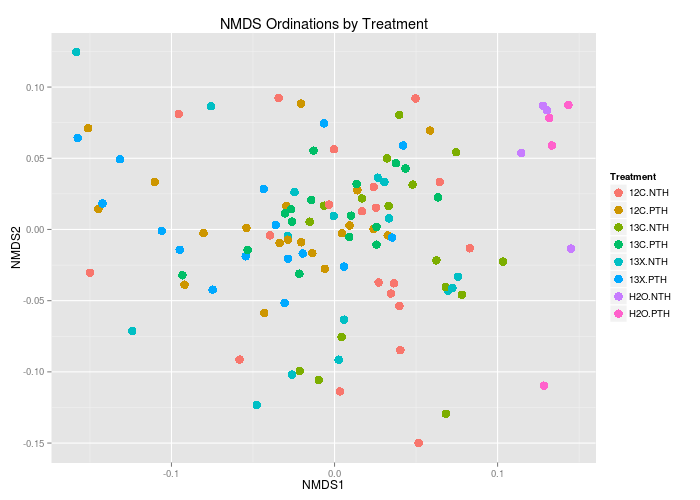

In [14]:
%%R -w 700 -h 500
nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = wunif.dist)
p.nmds = plot_ordination(physeq.thresh, nmds, justDF = TRUE)
#print(p)


asNumeric = function(x) { as.numeric(as.character(x)) }

p.nmds1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = Treatment), size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Treatment") + scale_shape_manual(values = c(15,16,17,18))

print(p.nmds1)

In [44]:
%%R
ggsave(filename = "figs/Treatment_ord.png", plot = p.nmds1, width =7, height =5)

Run 0 stress 0.1407221 
Run 1 stress 0.140722 
... New best solution
... procrustes: rmse 4.999057e-05  max resid 0.0002252457 
*** Solution reached


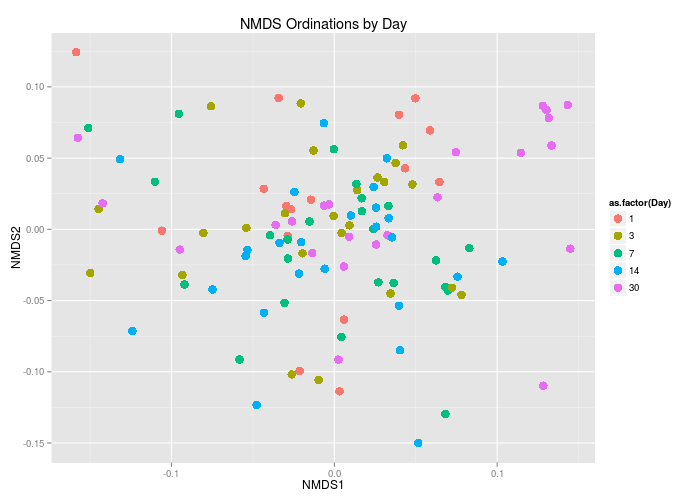

In [16]:
%%R -w 700 -h 500
nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = wunif.dist)
p.nmds = plot_ordination(physeq.thresh, nmds, justDF = TRUE)
#print(p)

asNumeric = function(x) { as.numeric(as.character(x)) }

p.nmdsmonth = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Day)), size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Day") + scale_shape_manual(values = c(15,16,17,18))

print(p.nmdsmonth)

In [50]:
%%R
ggsave(filename = "figs/Month_ord.png", plot = p.nmdsmonth, width =7, height =5)

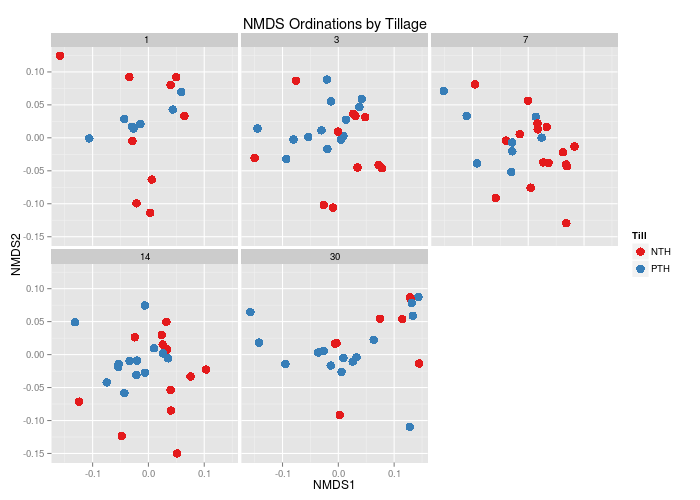

In [27]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = Till), size = 4)  +
        facet_wrap(~Day) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Tillage")


p.nmds3 = p.nmds3 + scale_color_brewer(palette="Set1")

print(p.nmds3)




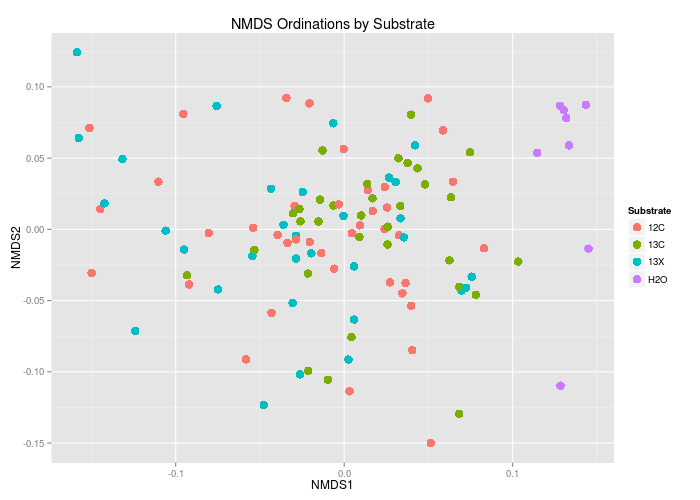

In [21]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = Substrate), size = 4)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Substrate")


 #scale_color_brewer(palette="Set1") + 

print(p.nmds3)

